# Image viewer

This notebook is for inspecting timelapse microscopy data, with associated sinhgle-cell labels and tracks, showing the infection of human macrophages with Mycobacterium Tuberculosis (Mtb), acquired on an Opera Phenix confocal microscope. 

In [70]:
import napari
from macrohet import dataio, tile, visualise
import os, glob
from tqdm.auto import tqdm
from skimage import io
import numpy as np

In [111]:
def update_slider(event):
    # only trigger if update comes from first axis (optional)
        #ind_lambda = viewer.dims.indices[0]
    time = viewer.dims.current_step[0]
    viewer.text_overlay.text = f"{time/2:1.1f} hours"
text_size = 24
napari_scale = [1.4949402023919043e-07, 1.4949402023919043e-07]


label_text_size = 15
### glimpse size
size = 500
### resized images are to this scale
scale = 6048/1200
scale_factor = 1/5.04
from napari_animation import Animation


825530

### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.

In [71]:
%%time
expt_ID = 'ND0002'
# base_dir = f'/mnt/DATA/macrohet/{expt_ID}/'
base_dir = f'/mnt/SYNO/macrohet_syno/{expt_ID}/'
metadata_fn = glob.glob(os.path.join(base_dir, 'acquisition/Images/Index*xml'))[0]
# metadata_fn = '/mnt/SYNO/macrohet_syno/ND0001/acquisition/ND0001__2023-10-27T14_12_54-Measurement 1/Images/Index.idx.xml'#glob.glob(os.path.join(base_dir, 'Images/Index*xml'))[0]
metadata = dataio.read_harmony_metadata(metadata_fn)  
# temporary hack to fix URL from incorrectly exported metadata
# metadata['URL'] = metadata.apply(dataio.generate_url, axis=1)
metadata

Reading metadata XML file...


0it [00:00, ?it/s]

Extracting metadata complete!
CPU times: user 43.4 s, sys: 729 ms, total: 44.2 s
Wall time: 44.1 s


,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0103K1F1P1R1,Ok,r01c03f01p01-ch1sk1fk1fl1.tiff,1,3,1,1,0,1,1,...,-2E-06,0.135466397,0,2023-11-30T17:22:09.49+00:00,640,706,40,1.1,0.2,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
1,0103K1F1P1R2,Ok,r01c03f01p01-ch2sk1fk1fl1.tiff,1,3,1,1,0,2,1,...,-2E-06,0.135466397,0,2023-11-30T17:22:09.723+00:00,488,522,40,1.1,0.1,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
2,0103K1F1P2R1,Ok,r01c03f01p02-ch1sk1fk1fl1.tiff,1,3,1,2,0,1,1,...,0,0.135468394,0,2023-11-30T17:22:10.067+00:00,640,706,40,1.1,0.2,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
3,0103K1F1P2R2,Ok,r01c03f01p02-ch2sk1fk1fl1.tiff,1,3,1,2,0,2,1,...,0,0.135468394,0,2023-11-30T17:22:10.287+00:00,488,522,40,1.1,0.1,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
4,0103K1F1P3R1,Ok,r01c03f01p03-ch1sk1fk1fl1.tiff,1,3,1,3,0,1,1,...,2E-06,0.135470405,0,2023-11-30T17:22:10.627+00:00,640,706,40,1.1,0.2,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388615,0612K150F9P1R2,Ok,r06c12f09p01-ch2sk150fk1fl1.tiff,6,12,9,1,149,2,1,...,-2E-06,0.1351538,268191.66,2023-12-03T20:06:16.08+00:00,488,522,40,1.1,0.1,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
388616,0612K150F9P2R1,Ok,r06c12f09p02-ch1sk150fk1fl1.tiff,6,12,9,2,149,1,1,...,0,0.135155797,268191.66,2023-12-03T20:06:16.423+00:00,640,706,40,1.1,0.2,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
388617,0612K150F9P2R2,Ok,r06c12f09p02-ch2sk150fk1fl1.tiff,6,12,9,2,149,2,1,...,0,0.135155797,268191.66,2023-12-03T20:06:16.657+00:00,488,522,40,1.1,0.1,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
388618,0612K150F9P3R1,Ok,r06c12f09p03-ch1sk150fk1fl1.tiff,6,12,9,3,149,1,1,...,2E-06,0.135157794,268191.66,2023-12-03T20:06:17+00:00,640,706,40,1.1,0.2,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [72]:
metadata_path = glob.glob(os.path.join(base_dir, 'acquisition/Assaylayout/*AssayLayout.xml'))[0]
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
Row Column                                              
3   1         UNI     CTRL             0             EC0
    2         UNI     CTRL             0             EC0
    3          WT     CTRL             0             EC0
    4          WT     CTRL             0             EC0
    5          WT      PZA            60            EC50
    6          WT      PZA            60            EC50
    7          WT      RIF           0.1            EC50
    8          WT      RIF           0.1            EC50
    9          WT      INH          0.04            EC50
    10         WT      INH          0.04            EC50
    11         WT      BDQ          0.02            EC50
    12         WT      BDQ          0.02            EC50
4   3          WT     CTRL             0             EC0
    4          WT     CTRL             0             EC0
    5          WT      PZA           400            EC99
    6          WT      PZA           400            EC99
    7          WT      RIF             2            EC99
    8          WT      RIF             2            EC99
    9          WT      INH             2            EC99
    10         WT      INH             2            EC99
    11         WT      BDQ           2.5            EC99
    12         WT      BDQ           2.5            EC99
5   3         RD1     CTRL             0             EC0
    4         RD1     CTRL             0             EC0
    5         RD1      PZA            60            EC50
    6         RD1      PZA            60            EC50
    7         RD1      RIF           0.1            EC50
    8         RD1      RIF           0.1            EC50
    9         RD1      INH          0.04            EC50
    10        RD1      INH          0.04            EC50
    11        RD1      BDQ          0.02            EC50
    12        RD1      BDQ          0.02            EC50
6   3         RD1     CTRL             0             EC0
    4         RD1     CTRL             0             EC0
    5         RD1      PZA           400            EC99
    6         RD1      PZA           400            EC99
    7         RD1      RIF             2            EC99
    8         RD1      RIF             2            EC99
    9         RD1      INH             2            EC99
    10        RD1      INH             2            EC99
    11        RD1      BDQ           2.5            EC99
    12        RD1      BDQ           2.5            EC99

### Define row and column of choice

In [73]:
acq_ID = row, column = (3, 4)

### Define subset if non-square tiling or more than one contiguous region of images in imaging well. 

In [5]:
# subset_field_IDs = ['1','6','7','8','11','12','13','14','15']

### Load images using zarr

In [10]:
import zarr

In [38]:
image_dir = os.path.join(base_dir, f'acquisition/zarr/{acq_ID}.zarr')
images = zarr.open(image_dir, mode='r')

### Now to lazily mosaic the images using Dask prior to viewing them.

1x (75,2,3) [TCZ] image stack takes approximately 1 minute to stitch together, so only load the one field of view I want.

In [124]:
%%time
# image_dir = os.path.join(base_dir, 'macrohet_images/Images_8bit')
image_dir = os.path.join(base_dir, 'acquisition/Images')
images = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, column, 
                             # subset_field_IDs=['16', '17',  '20', '21'], 
                             # n_tile_rows = 2, n_tile_cols = 2,
                             set_plane='max_proj',
                             # set_channel=1,
                             # set_time = 1,
#                             input_transforms = [input_transforms]
                            )#.compute().compute()
images

CPU times: user 1.14 s, sys: 1.77 ms, total: 1.14 s
Wall time: 1.14 s


dask.array<max-aggregate, shape=(150, 2, 6048, 6048), dtype=uint16, chunksize=(1, 2, 2160, 2160), chunktype=numpy.ndarray>

In [125]:
%%time
images = images.compute().compute()

CPU times: user 6h 55min 49s, sys: 40min 38s, total: 7h 36min 27s
Wall time: 20min 32s


In [114]:
viewer = napari.Viewer(title = f'{expt_ID} vis with tracks')

viewer.add_image(images, channel_axis = 1, 
                 scale = napari_scale, contrast_limits=[[280, 1000],[0,3000]])
# viewer.theme = 'light'
viewer.scale_bar.visible = True
viewer.scale_bar.unit = 'm'
viewer.scale_bar.font_size = text_size
viewer.text_overlay.visible = True
viewer.text_overlay.color = 'white'
viewer.text_overlay.position = 'bottom_left'
viewer.text_overlay.font_size = text_size
viewer.dims.events.current_step.connect(update_slider)

[<Image layer 'Image' at 0x7fae798d1220>,
 <Image layer 'Image [1]' at 0x7fb102c0fc40>]

### Load masks

In [208]:
fn = '/mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4).h5'
with btrack.io.HDF5FileHandler(fn, 'r', obj_type='obj_type_1') as reader:
    segmentation = reader.segmentation

[INFO][2024/01/17 02:41:43 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4).h5...
[INFO][2024/01/17 02:42:03 pm] Loading segmentation (150, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (150, 6048, 6048)
[INFO][2024/01/17 02:42:03 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4).h5


In [209]:
viewer.add_labels(segmentation, scale = napari_scale)

<Labels layer 'segmentation' at 0x7fade3b7e6d0>

### Load and overlay some tracks

In [133]:
track_dict ={}
for fn in glob.glob(os.path.join(base_dir, 'labels/testing*')):
    with btrack.io.HDF5FileHandler(fn, 'r', obj_type='obj_type_1') as reader:
        tracks = reader.tracks
    track_dict[os.path.basename(fn)] = tracks

[INFO][2024/01/17 11:58:15 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4).h5...
[INFO][2024/01/17 11:58:15 am] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/01/17 11:58:15 am] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/01/17 11:58:15 am] Loading objects/obj_type_1 (72361, 5) (72361 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (72361, 5) (72361 filtered: None)
[INFO][2024/01/17 11:58:18 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4).h5
[INFO][2024/01/17 11:58:18 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4)_config_segrate_0.05_probass_0.05.json.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testi

In [197]:
# Create an animation object
animation = Animation(viewer)
viewer.dims.current_step = (0, 3023, 3023)
# Capture the initial frame
animation.capture_keyframe()
viewer.dims.current_step = (150, 3023, 3023)
# Capture the last frame (no need to change camera angles)
animation.capture_keyframe(steps =600)

# Animate to create a static video (from the first frame to the last frame)
animation.animate('/home/dayn/ND2_slow.mp4', canvas_only=True)

Rendering frames...


100%|████████████████████████████████████████████████████████| 901/901 [01:12<00:00, 12.49it/s]


In [195]:
for key in tqdm(track_dict.keys()):
    tracks = track_dict[key]
    tracks = [t for t in tracks if len(t) >15]
    napari_tracks, _, _ = btrack.utils.tracks_to_napari(tracks, ndim = 2)
    viewer.add_tracks(napari_tracks, name = 'filt_'+key, scale = (napari_scale[0]/scale_factor,napari_scale[0]/scale_factor))

  0%|          | 0/12 [00:00<?, ?it/s]

In [202]:
for key in tqdm(track_dict.keys()):
    tracks = track_dict[key]
    print(key, np.mean([len(t) for t in tracks if len(t) > 50]))
    print(len(tracks))

  0%|          | 0/12 [00:00<?, ?it/s]

testing_(3, 4).h5 83.83510638297872
27889
testing_(3, 4)_config_segrate_0.05_probass_0.05.json.h5 85.0327868852459
27742
testing_(3, 4)_config_segrate_0.05_probass_0.1.json.h5 83.83510638297872
27889
testing_(3, 4)_config_segrate_0.05_probass_0.15000000000000002.json.h5 84.14285714285714
28021
testing_(3, 4)_config_segrate_0.1_probass_0.05.json.h5 85.0327868852459
27742
testing_(3, 4)_config_segrate_0.1_probass_0.1.json.h5 83.83510638297872
27889
testing_(3, 4)_config_segrate_0.1_probass_0.15000000000000002.json.h5 84.14285714285714
28021
testing_(3, 4)_config_segrate_0.15000000000000002_probass_0.05.json.h5 85.0327868852459
27742
testing_(3, 4)_config_segrate_0.15000000000000002_probass_0.1.json.h5 83.83510638297872
27889
testing_(3, 4)_config_segrate_0.15000000000000002_probass_0.15000000000000002.json.h5 84.14285714285714
28021
testing_(3, 4)_config_segrate_0.1_probass_0.010000000000000002.json.h5 84.43715846994536
27631
testing_(3, 4)_config_segrate_0.1_probass_0.9.json.h5 82.69430

In [212]:
# Create an animation object
animation = Animation(viewer)
viewer.dims.current_step = (0, 3023, 3023)
# Capture the initial frame
animation.capture_keyframe()
viewer.dims.current_step = (150, 3023, 3023)
# Capture the last frame (no need to change camera angles)
animation.capture_keyframe(steps =900)

# Animate to create a static video (from the first frame to the last frame)
animation.animate('/home/dayn/ND2_slow_w_ID_tracks.mp4', canvas_only=True)

Rendering frames...


100%|████████████████████████████████████████████████████████| 901/901 [01:22<00:00, 10.94it/s]


### Focusing on one set of tracks

In [214]:
fn = '/mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4)_config_segrate_0.05_probass_0.05.json.h5'
with btrack.io.HDF5FileHandler(fn, 'r', obj_type='obj_type_1') as reader:
    seg = reader.segmentation
    tracks = reader.tracks
recolored_segmentation = btrack.utils.update_segmentation(seg, tracks ,scale = (1/scale_factor,1/scale_factor))


[INFO][2024/01/17 04:33:41 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4)_config_segrate_0.05_probass_0.05.json.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4)_config_segrate_0.05_probass_0.05.json.h5...
[INFO][2024/01/17 04:34:00 pm] Loading segmentation (150, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (150, 6048, 6048)
[INFO][2024/01/17 04:34:00 pm] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/01/17 04:34:00 pm] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/01/17 04:34:00 pm] Loading objects/obj_type_1 (72015, 5) (72015 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (72015, 5) (72015 filtered: None)
[INFO][2024/01/17 04:34:05 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4)_config_segrate_0.05_probass_0.05.json.h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/te

In [215]:
viewer.add_labels(recolored_segmentation, scale = napari_scale)

<Labels layer 'recolored_segmentation' at 0x7fad8c5dcac0>

In [217]:
viewer.add_labels(segmentation, scale = napari_scale)

<Labels layer 'segmentation' at 0x7fad8c5dc970>

# Testing best set of tracks

In [219]:
import seaborn as sns
import matplotlib.pyplot as plt

/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(0.0, 500.0)

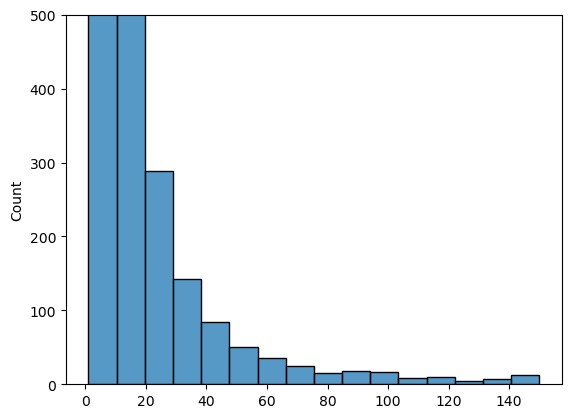

In [220]:
sns.histplot([len(t) for t in tracks])
plt.ylim(0, 500)

In [221]:
filtered_tracks = [t for t in tracks if len(t) >75]
napari_tracks, _, _ = btrack.utils.tracks_to_napari(filtered_tracks, ndim = 2)
viewer.add_tracks(napari_tracks, name = 'filtered_tracks', scale = (napari_scale[0]/scale_factor,napari_scale[0]/scale_factor))

<Tracks layer 'filtered_tracks' at 0x7fad4d2c6460>

### Trying different tracking approaches

In [224]:
track_fn = fn = '/mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4)_config_segrate_0.05_probass_0.05.json.h5'
with btrack.io.HDF5FileHandler(fn, 'r', obj_type='obj_type_1') as reader:
    objects = reader.objects

[INFO][2024/01/17 04:39:59 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4)_config_segrate_0.05_probass_0.05.json.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4)_config_segrate_0.05_probass_0.05.json.h5...
[INFO][2024/01/17 04:39:59 pm] Loading objects/obj_type_1 (72015, 5) (72015 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (72015, 5) (72015 filtered: None)
[INFO][2024/01/17 04:40:00 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4)_config_segrate_0.05_probass_0.05.json.h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4)_config_segrate_0.05_probass_0.05.json.h5


In [226]:
config_fn = '/home/dayn/analysis/models/btrack/config_segrate_0.05_probass_0.05.json'

In [228]:
for search_radius in tqdm([5, 10, 20, 40, 60, 80, 100, 200]):
    # config_fn = '/home/dayn/analysis/models/btrack/particle_config_pnassign.json'

    # initialise a tracker session using a context manager
    with btrack.BayesianTracker() as tracker:
        # configure the tracker using a config file
        tracker.configure(config_fn)
        # set max search radius
        tracker.max_search_radius = search_radius
        # define tracking method
        tracker.tracking_updates = ["MOTION", "VISUAL"]
        # redefine features so that both channels are included in track measurements
        tracker.features = list(objects[0].properties.keys())
        # append the objects to be tracked
        tracker.append(objects)
        # set the tracking volume
        tracker.volume=((0, masks.shape[-2]*scale_factor), (0, masks.shape[-1]*scale_factor))
        # track them (in interactive mode)
        tracker.track(step_size=25)
        # generate hypotheses and run the global optimizer
        tracker.optimize()
        # store the tracks
        tracks = tracker.tracks
    
    with btrack.io.HDF5FileHandler(os.path.join(base_dir, f'labels/visual_search_radius_{search_radius}.h5'), 
                                       'w', 
                                       obj_type='obj_type_1'
                                       ) as writer:
    #             writer.write_objects(objects)
            writer.write_tracks(tracks)
            # writer.write_segmentation(recolored_segmentation)

for search_radius in tqdm([5, 10, 20, 40, 60, 80, 100, 200]):
    # initialise a tracker session using a context manager
    with btrack.BayesianTracker() as tracker:
        # configure the tracker using a config file
        tracker.configure(config_fn)
        # set max search radius
        tracker.max_search_radius = search_radius
        # define tracking method
        tracker.tracking_updates = ["MOTION",]
        # redefine features so that both channels are included in track measurements
        tracker.features = list(objects[0].properties.keys())
        # append the objects to be tracked
        tracker.append(objects)
        # set the tracking volume
        tracker.volume=((0, masks.shape[-2]*scale_factor), (0, masks.shape[-1]*scale_factor))
        # track them (in interactive mode)
        tracker.track(step_size=25)
        # generate hypotheses and run the global optimizer
        tracker.optimize()
        # store the tracks
        tracks = tracker.tracks
    
    with btrack.io.HDF5FileHandler(os.path.join(base_dir, f'labels/motion_search_radius_{search_radius}.h5'), 
                                       'w', 
                                       obj_type='obj_type_1'
                                       ) as writer:
    #             writer.write_objects(objects)
            writer.write_tracks(tracks)
            # writer.write_segmentation(recolored_segmentation)

  0%|          | 0/8 [00:00<?, ?it/s]

[INFO][2024/01/17 04:45:00 pm] Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
INFO:btrack.libwrapper:Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
[INFO][2024/01/17 04:45:00 pm] Starting BayesianTracker session
INFO:btrack.core:Starting BayesianTracker session
[INFO][2024/01/17 04:45:00 pm] Loading configuration file: /home/dayn/analysis/models/btrack/config_segrate_0.05_probass_0.05.json
INFO:btrack.config:Loading configuration file: /home/dayn/analysis/models/btrack/config_segrate_0.05_probass_0.05.json
[INFO][2024/01/17 04:45:00 pm] Objects are of type: <class 'list'>
INFO:btrack.io.utils:Objects are of type: <class 'list'>
[INFO][2024/01/17 04:45:02 pm] Starting tracking... 
INFO:btrack.core:Starting tracking... 
[INFO][2024/01/17 04:45:02 pm] Update using: ['VISUAL', 'MOTION']
INFO:btrack.core:Update using: ['VISUAL', 'MOTION']
[INFO][2024/01/17 04:45:02 pm] Tracking objects in frames 0 to 24 (of 150)...
INFO:btrack.core:Tracking objects 

GLPK Integer Optimizer 5.0
111884 rows, 1561989 columns, 3068036 non-zeros
1561989 integer variables, all of which are binary
Preprocessing...
55942 rows, 1561989 columns, 3068036 non-zeros
1561989 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 55942
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
55942 rows, 1561989 columns, 3068036 non-zeros
*     0: obj =   3.548403784e+05 inf =   0.000e+00 (1504096)
*   207: obj =   3.538061045e+05 inf =   0.000e+00 (1411440)
Perturbing LP to avoid stalling [320]...
*   414: obj =   3.527947563e+05 inf =   0.000e+00 (1312566)
*   625: obj =   3.517348729e+05 inf =   0.000e+00 (1235035)
*   840: obj =   3.506955232e+05 inf =   0.000e+00 (1175953)
*  1048: obj =   3.497732296e+05 inf =   0.000e+00 (1099993) 1
*  1251: obj =   3.489667532e+05 inf =   0.000e+00 (1081502)
*  1450: ob

[INFO][2024/01/17 05:06:39 pm] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session
[INFO][2024/01/17 05:06:39 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/visual_search_radius_5.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/visual_search_radius_5.h5...
[INFO][2024/01/17 05:06:39 pm] Writing objects/obj_type_1
INFO:btrack.io.hdf:Writing objects/obj_type_1
[INFO][2024/01/17 05:06:39 pm] Writing labels/obj_type_1
INFO:btrack.io.hdf:Writing labels/obj_type_1
[INFO][2024/01/17 05:06:39 pm] Loading objects/obj_type_1 (41761, 5) (41761 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (41761, 5) (41761 filtered: None)
[INFO][2024/01/17 05:06:40 pm] Writing properties/obj_type_1/major_axis_length (41761,)
INFO:btrack.io.hdf:Writing properties/obj_type_1/major_axis_length (41761,)
[INFO][2024/01/17 05:06:40 pm] Writing properties/obj_type_1/class_id (41761,)
INFO:btrack.io.hdf:Writing properties/obj_type_1/

GLPK Integer Optimizer 5.0
107044 rows, 1436618 columns, 2819714 non-zeros
1436618 integer variables, all of which are binary
Preprocessing...
53522 rows, 1436618 columns, 2819714 non-zeros
1436618 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 53522
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
53522 rows, 1436618 columns, 2819714 non-zeros
*     0: obj =   3.387805517e+05 inf =   0.000e+00 (1380488)
*   224: obj =   3.376799014e+05 inf =   0.000e+00 (1288393)
Perturbing LP to avoid stalling [318]...
*   451: obj =   3.365762354e+05 inf =   0.000e+00 (1197575)
*   682: obj =   3.354348887e+05 inf =   0.000e+00 (1074620)
*   919: obj =   3.342805615e+05 inf =   0.000e+00 (1001813)
*  1143: obj =   3.333840652e+05 inf =   0.000e+00 (969033) 1
*  1368: obj =   3.323898235e+05 inf =   0.000e+00 (963912)
*  1581: obj 

[INFO][2024/01/17 05:25:08 pm] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session
[INFO][2024/01/17 05:25:09 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/visual_search_radius_10.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/visual_search_radius_10.h5...
[INFO][2024/01/17 05:25:09 pm] Writing objects/obj_type_1
INFO:btrack.io.hdf:Writing objects/obj_type_1
[INFO][2024/01/17 05:25:09 pm] Writing labels/obj_type_1
INFO:btrack.io.hdf:Writing labels/obj_type_1
[INFO][2024/01/17 05:25:09 pm] Loading objects/obj_type_1 (54010, 5) (54010 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (54010, 5) (54010 filtered: None)
[INFO][2024/01/17 05:25:10 pm] Writing properties/obj_type_1/major_axis_length (54010,)
INFO:btrack.io.hdf:Writing properties/obj_type_1/major_axis_length (54010,)
[INFO][2024/01/17 05:25:10 pm] Writing properties/obj_type_1/class_id (54010,)
INFO:btrack.io.hdf:Writing properties/obj_type_

GLPK Integer Optimizer 5.0
105424 rows, 1296531 columns, 2540350 non-zeros
1296531 integer variables, all of which are binary
Preprocessing...
52712 rows, 1296531 columns, 2540350 non-zeros
1296531 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 52712
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
52712 rows, 1296531 columns, 2540350 non-zeros
*     0: obj =   3.327735853e+05 inf =   0.000e+00 (1239967)
*   247: obj =   3.315408683e+05 inf =   0.000e+00 (1139293)
Perturbing LP to avoid stalling [324]...
*   502: obj =   3.302153111e+05 inf =   0.000e+00 (1028002)
*   768: obj =   3.286797402e+05 inf =   0.000e+00 (921541)
*  1027: obj =   3.274770733e+05 inf =   0.000e+00 (854023) 1
*  1279: obj =   3.264177549e+05 inf =   0.000e+00 (784836)
*  1535: obj =   3.251134341e+05 inf =   0.000e+00 (812173)
*  1774: obj = 

[INFO][2024/01/17 05:40:51 pm] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session
[INFO][2024/01/17 05:40:51 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/visual_search_radius_20.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/visual_search_radius_20.h5...
[INFO][2024/01/17 05:40:55 pm] Writing objects/obj_type_1
INFO:btrack.io.hdf:Writing objects/obj_type_1
[INFO][2024/01/17 05:40:55 pm] Writing labels/obj_type_1
INFO:btrack.io.hdf:Writing labels/obj_type_1
[INFO][2024/01/17 05:40:55 pm] Loading objects/obj_type_1 (67617, 5) (67617 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (67617, 5) (67617 filtered: None)
[INFO][2024/01/17 05:40:55 pm] Writing properties/obj_type_1/major_axis_length (67617,)
INFO:btrack.io.hdf:Writing properties/obj_type_1/major_axis_length (67617,)
[INFO][2024/01/17 05:40:55 pm] Writing properties/obj_type_1/class_id (67617,)
INFO:btrack.io.hdf:Writing properties/obj_type_

GLPK Integer Optimizer 5.0
104968 rows, 1267837 columns, 2483190 non-zeros
1267837 integer variables, all of which are binary
Preprocessing...
52484 rows, 1267837 columns, 2483190 non-zeros
1267837 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 52484
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
52484 rows, 1267837 columns, 2483190 non-zeros
*     0: obj =   3.307951383e+05 inf =   0.000e+00 (1210924)
*   259: obj =   3.294033594e+05 inf =   0.000e+00 (1110286)
Perturbing LP to avoid stalling [339]...
*   521: obj =   3.280122625e+05 inf =   0.000e+00 (997124)
*   800: obj =   3.261797072e+05 inf =   0.000e+00 (905526)
*  1074: obj =   3.246846700e+05 inf =   0.000e+00 (812092) 1
*  1335: obj =   3.235365879e+05 inf =   0.000e+00 (760258)
*  1601: obj =   3.221310745e+05 inf =   0.000e+00 (714777)
*  1853: obj =  

[INFO][2024/01/17 05:55:59 pm] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session
[INFO][2024/01/17 05:56:00 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/visual_search_radius_40.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/visual_search_radius_40.h5...
[INFO][2024/01/17 05:56:01 pm] Writing objects/obj_type_1
INFO:btrack.io.hdf:Writing objects/obj_type_1
[INFO][2024/01/17 05:56:01 pm] Writing labels/obj_type_1
INFO:btrack.io.hdf:Writing labels/obj_type_1
[INFO][2024/01/17 05:56:01 pm] Loading objects/obj_type_1 (70278, 5) (70278 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (70278, 5) (70278 filtered: None)
[INFO][2024/01/17 05:56:01 pm] Writing properties/obj_type_1/major_axis_length (70278,)
INFO:btrack.io.hdf:Writing properties/obj_type_1/major_axis_length (70278,)
[INFO][2024/01/17 05:56:01 pm] Writing properties/obj_type_1/class_id (70278,)
INFO:btrack.io.hdf:Writing properties/obj_type_

GLPK Integer Optimizer 5.0
105148 rows, 1270715 columns, 2488856 non-zeros
1270715 integer variables, all of which are binary
Preprocessing...
52574 rows, 1270715 columns, 2488856 non-zeros
1270715 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 52574
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
52574 rows, 1270715 columns, 2488856 non-zeros
*     0: obj =   3.310782088e+05 inf =   0.000e+00 (1213380)
*   258: obj =   3.296861398e+05 inf =   0.000e+00 (1117467)
Perturbing LP to avoid stalling [340]...
*   522: obj =   3.282030610e+05 inf =   0.000e+00 (1010841)
*   800: obj =   3.263404015e+05 inf =   0.000e+00 (910516)
*  1074: obj =   3.248052922e+05 inf =   0.000e+00 (819735) 1
*  1337: obj =   3.235810403e+05 inf =   0.000e+00 (805595)
*  1598: obj =   3.222623076e+05 inf =   0.000e+00 (779308)
*  1847: obj = 

[INFO][2024/01/17 06:11:09 pm] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session
[INFO][2024/01/17 06:11:10 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/visual_search_radius_60.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/visual_search_radius_60.h5...
[INFO][2024/01/17 06:11:11 pm] Writing objects/obj_type_1
INFO:btrack.io.hdf:Writing objects/obj_type_1
[INFO][2024/01/17 06:11:11 pm] Writing labels/obj_type_1
INFO:btrack.io.hdf:Writing labels/obj_type_1
[INFO][2024/01/17 06:11:11 pm] Loading objects/obj_type_1 (71516, 5) (71516 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (71516, 5) (71516 filtered: None)
[INFO][2024/01/17 06:11:11 pm] Writing properties/obj_type_1/major_axis_length (71516,)
INFO:btrack.io.hdf:Writing properties/obj_type_1/major_axis_length (71516,)
[INFO][2024/01/17 06:11:11 pm] Writing properties/obj_type_1/class_id (71516,)
INFO:btrack.io.hdf:Writing properties/obj_type_

GLPK Integer Optimizer 5.0
105096 rows, 1271155 columns, 2489762 non-zeros
1271155 integer variables, all of which are binary
Preprocessing...
52548 rows, 1271155 columns, 2489762 non-zeros
1271155 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 52548
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
52548 rows, 1271155 columns, 2489762 non-zeros
*     0: obj =   3.309276007e+05 inf =   0.000e+00 (1213708)
*   244: obj =   3.296016696e+05 inf =   0.000e+00 (1123198)
Perturbing LP to avoid stalling [344]...
*   508: obj =   3.281041920e+05 inf =   0.000e+00 (1028632)
*   787: obj =   3.262111762e+05 inf =   0.000e+00 (918884)
*  1070: obj =   3.244439419e+05 inf =   0.000e+00 (857989)
*  1331: obj =   3.232570134e+05 inf =   0.000e+00 (810706) 1
*  1590: obj =   3.219874151e+05 inf =   0.000e+00 (747496)
*  1841: obj = 

[INFO][2024/01/17 06:26:21 pm] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session
[INFO][2024/01/17 06:26:21 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/visual_search_radius_80.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/visual_search_radius_80.h5...
[INFO][2024/01/17 06:26:22 pm] Writing objects/obj_type_1
INFO:btrack.io.hdf:Writing objects/obj_type_1
[INFO][2024/01/17 06:26:22 pm] Writing labels/obj_type_1
INFO:btrack.io.hdf:Writing labels/obj_type_1
[INFO][2024/01/17 06:26:22 pm] Loading objects/obj_type_1 (71851, 5) (71851 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (71851, 5) (71851 filtered: None)
[INFO][2024/01/17 06:26:23 pm] Writing properties/obj_type_1/major_axis_length (71851,)
INFO:btrack.io.hdf:Writing properties/obj_type_1/major_axis_length (71851,)
[INFO][2024/01/17 06:26:23 pm] Writing properties/obj_type_1/class_id (71851,)
INFO:btrack.io.hdf:Writing properties/obj_type_

GLPK Integer Optimizer 5.0
105100 rows, 1271359 columns, 2490168 non-zeros
1271359 integer variables, all of which are binary
Preprocessing...
52550 rows, 1271359 columns, 2490168 non-zeros
1271359 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 52550
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
52550 rows, 1271359 columns, 2490168 non-zeros
*     0: obj =   3.309047404e+05 inf =   0.000e+00 (1213892)
*   261: obj =   3.294996440e+05 inf =   0.000e+00 (1113091)
Perturbing LP to avoid stalling [343]...
*   526: obj =   3.279769556e+05 inf =   0.000e+00 (1011979)
*   809: obj =   3.260224351e+05 inf =   0.000e+00 (916453)
*  1089: obj =   3.243592877e+05 inf =   0.000e+00 (830065)
*  1352: obj =   3.231726860e+05 inf =   0.000e+00 (755247) 1
*  1616: obj =   3.218286047e+05 inf =   0.000e+00 (784662)
*  1870: obj = 

[INFO][2024/01/17 06:41:37 pm] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session
[INFO][2024/01/17 06:41:37 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/visual_search_radius_100.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/visual_search_radius_100.h5...
[INFO][2024/01/17 06:41:38 pm] Writing objects/obj_type_1
INFO:btrack.io.hdf:Writing objects/obj_type_1
[INFO][2024/01/17 06:41:38 pm] Writing labels/obj_type_1
INFO:btrack.io.hdf:Writing labels/obj_type_1
[INFO][2024/01/17 06:41:38 pm] Loading objects/obj_type_1 (71922, 5) (71922 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (71922, 5) (71922 filtered: None)
[INFO][2024/01/17 06:41:39 pm] Writing properties/obj_type_1/major_axis_length (71922,)
INFO:btrack.io.hdf:Writing properties/obj_type_1/major_axis_length (71922,)
[INFO][2024/01/17 06:41:39 pm] Writing properties/obj_type_1/class_id (71922,)
INFO:btrack.io.hdf:Writing properties/obj_typ

GLPK Integer Optimizer 5.0
105160 rows, 1270806 columns, 2489032 non-zeros
1270806 integer variables, all of which are binary
Preprocessing...
52580 rows, 1270806 columns, 2489032 non-zeros
1270806 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 52580
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
52580 rows, 1270806 columns, 2489032 non-zeros
*     0: obj =   3.311058971e+05 inf =   0.000e+00 (1213300)
*   257: obj =   3.297139930e+05 inf =   0.000e+00 (1118096)
Perturbing LP to avoid stalling [343]...
*   521: obj =   3.282042286e+05 inf =   0.000e+00 (1012583)
*   802: obj =   3.262877764e+05 inf =   0.000e+00 (916402)
*  1083: obj =   3.245732451e+05 inf =   0.000e+00 (842349)
*  1344: obj =   3.233991895e+05 inf =   0.000e+00 (772712) 1
*  1606: obj =   3.220799995e+05 inf =   0.000e+00 (709400)
*  1856: obj = 

[INFO][2024/01/17 06:56:53 pm] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session
[INFO][2024/01/17 06:56:53 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/visual_search_radius_200.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/visual_search_radius_200.h5...
[INFO][2024/01/17 06:56:54 pm] Writing objects/obj_type_1
INFO:btrack.io.hdf:Writing objects/obj_type_1
[INFO][2024/01/17 06:56:54 pm] Writing labels/obj_type_1
INFO:btrack.io.hdf:Writing labels/obj_type_1
[INFO][2024/01/17 06:56:54 pm] Loading objects/obj_type_1 (71952, 5) (71952 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (71952, 5) (71952 filtered: None)
[INFO][2024/01/17 06:56:54 pm] Writing properties/obj_type_1/major_axis_length (71952,)
INFO:btrack.io.hdf:Writing properties/obj_type_1/major_axis_length (71952,)
[INFO][2024/01/17 06:56:54 pm] Writing properties/obj_type_1/class_id (71952,)
INFO:btrack.io.hdf:Writing properties/obj_typ

  0%|          | 0/8 [00:00<?, ?it/s]

[INFO][2024/01/17 06:56:55 pm] Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
INFO:btrack.libwrapper:Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
[INFO][2024/01/17 06:56:55 pm] Starting BayesianTracker session
INFO:btrack.core:Starting BayesianTracker session
[INFO][2024/01/17 06:56:55 pm] Loading configuration file: /home/dayn/analysis/models/btrack/config_segrate_0.05_probass_0.05.json
INFO:btrack.config:Loading configuration file: /home/dayn/analysis/models/btrack/config_segrate_0.05_probass_0.05.json
[INFO][2024/01/17 06:56:55 pm] Objects are of type: <class 'list'>
INFO:btrack.io.utils:Objects are of type: <class 'list'>
[INFO][2024/01/17 06:56:56 pm] Starting tracking... 
INFO:btrack.core:Starting tracking... 
[INFO][2024/01/17 06:56:56 pm] Update using: ['MOTION']
INFO:btrack.core:Update using: ['MOTION']
[INFO][2024/01/17 06:56:56 pm] Tracking objects in frames 0 to 24 (of 150)...
INFO:btrack.core:Tracking objects in frames 0 to 24 (o

GLPK Integer Optimizer 5.0
143260 rows, 1754697 columns, 3437764 non-zeros
1754697 integer variables, all of which are binary
Preprocessing...
71630 rows, 1754697 columns, 3437764 non-zeros
1754697 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 71630
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
71630 rows, 1754697 columns, 3437764 non-zeros
*     0: obj =   4.537288905e+05 inf =   0.000e+00 (1680622)
*   182: obj =   4.528021896e+05 inf =   0.000e+00 (1591547)
Perturbing LP to avoid stalling [316]...
*   364: obj =   4.519495331e+05 inf =   0.000e+00 (1509069)
*   545: obj =   4.511447565e+05 inf =   0.000e+00 (1425718)
*   736: obj =   4.501240889e+05 inf =   0.000e+00 (1356734)
*   923: obj =   4.492761402e+05 inf =   0.000e+00 (1299210)
*  1105: obj =   4.485312468e+05 inf =   0.000e+00 (1221111) 1
*  1286: ob

[INFO][2024/01/17 07:22:33 pm] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session
[INFO][2024/01/17 07:22:34 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/motion_search_radius_5.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/motion_search_radius_5.h5...
[INFO][2024/01/17 07:22:34 pm] Writing objects/obj_type_1
INFO:btrack.io.hdf:Writing objects/obj_type_1
[INFO][2024/01/17 07:22:34 pm] Writing labels/obj_type_1
INFO:btrack.io.hdf:Writing labels/obj_type_1
[INFO][2024/01/17 07:22:34 pm] Loading objects/obj_type_1 (54457, 5) (54457 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (54457, 5) (54457 filtered: None)
[INFO][2024/01/17 07:22:35 pm] Writing properties/obj_type_1/major_axis_length (54457,)
INFO:btrack.io.hdf:Writing properties/obj_type_1/major_axis_length (54457,)
[INFO][2024/01/17 07:22:35 pm] Writing properties/obj_type_1/class_id (54457,)
INFO:btrack.io.hdf:Writing properties/obj_type_1/

GLPK Integer Optimizer 5.0
138248 rows, 1655589 columns, 3242054 non-zeros
1655589 integer variables, all of which are binary
Preprocessing...
69124 rows, 1655589 columns, 3242054 non-zeros
1655589 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 69124
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
69124 rows, 1655589 columns, 3242054 non-zeros
*     0: obj =   4.366932294e+05 inf =   0.000e+00 (1582897)
*   196: obj =   4.356343074e+05 inf =   0.000e+00 (1491712)
Perturbing LP to avoid stalling [329]...
*   391: obj =   4.346634738e+05 inf =   0.000e+00 (1421306)
*   592: obj =   4.335204276e+05 inf =   0.000e+00 (1330235)
*   819: obj =   4.316873207e+05 inf =   0.000e+00 (1283157)
*  1045: obj =   4.299498871e+05 inf =   0.000e+00 (1225008)
*  1258: obj =   4.285595904e+05 inf =   0.000e+00 (1147354) 1
*  1462: ob

[INFO][2024/01/17 07:45:56 pm] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session
[INFO][2024/01/17 07:45:56 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/motion_search_radius_10.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/motion_search_radius_10.h5...
[INFO][2024/01/17 07:45:57 pm] Writing objects/obj_type_1
INFO:btrack.io.hdf:Writing objects/obj_type_1
[INFO][2024/01/17 07:45:57 pm] Writing labels/obj_type_1
INFO:btrack.io.hdf:Writing labels/obj_type_1
[INFO][2024/01/17 07:45:57 pm] Loading objects/obj_type_1 (66965, 5) (66965 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (66965, 5) (66965 filtered: None)
[INFO][2024/01/17 07:45:57 pm] Writing properties/obj_type_1/major_axis_length (66965,)
INFO:btrack.io.hdf:Writing properties/obj_type_1/major_axis_length (66965,)
[INFO][2024/01/17 07:45:57 pm] Writing properties/obj_type_1/class_id (66965,)
INFO:btrack.io.hdf:Writing properties/obj_type_

GLPK Integer Optimizer 5.0
138592 rows, 1653641 columns, 3237986 non-zeros
1653641 integer variables, all of which are binary
Preprocessing...
69296 rows, 1653641 columns, 3237986 non-zeros
1653641 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 69296
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
69296 rows, 1653641 columns, 3237986 non-zeros
*     0: obj =   4.375118489e+05 inf =   0.000e+00 (1580031)
*   195: obj =   4.363467384e+05 inf =   0.000e+00 (1502860)
Perturbing LP to avoid stalling [387]...
*   396: obj =   4.349929769e+05 inf =   0.000e+00 (1435545)
*   602: obj =   4.334933335e+05 inf =   0.000e+00 (1378355)
*   815: obj =   4.318245200e+05 inf =   0.000e+00 (1324281)
*  1069: obj =   4.291448800e+05 inf =   0.000e+00 (1285781)
*  1317: obj =   4.267301947e+05 inf =   0.000e+00 (1229185)
*  1531: obj 

[INFO][2024/01/17 08:10:13 pm] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session
[INFO][2024/01/17 08:10:13 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/motion_search_radius_20.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/motion_search_radius_20.h5...
[INFO][2024/01/17 08:10:14 pm] Writing objects/obj_type_1
INFO:btrack.io.hdf:Writing objects/obj_type_1
[INFO][2024/01/17 08:10:14 pm] Writing labels/obj_type_1
INFO:btrack.io.hdf:Writing labels/obj_type_1
[INFO][2024/01/17 08:10:14 pm] Loading objects/obj_type_1 (71949, 5) (71949 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (71949, 5) (71949 filtered: None)
[INFO][2024/01/17 08:10:15 pm] Writing properties/obj_type_1/major_axis_length (71949,)
INFO:btrack.io.hdf:Writing properties/obj_type_1/major_axis_length (71949,)
[INFO][2024/01/17 08:10:15 pm] Writing properties/obj_type_1/class_id (71949,)
INFO:btrack.io.hdf:Writing properties/obj_type_

GLPK Integer Optimizer 5.0
138616 rows, 1653687 columns, 3238066 non-zeros
1653687 integer variables, all of which are binary
Preprocessing...
69308 rows, 1653687 columns, 3238066 non-zeros
1653687 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 69308
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
69308 rows, 1653687 columns, 3238066 non-zeros
*     0: obj =   4.375611706e+05 inf =   0.000e+00 (1580041)
*   193: obj =   4.364093024e+05 inf =   0.000e+00 (1502191)
Perturbing LP to avoid stalling [387]...
*   393: obj =   4.350423533e+05 inf =   0.000e+00 (1442035)
*   596: obj =   4.335946303e+05 inf =   0.000e+00 (1371716)
*   758: obj =   4.323900816e+05 inf =   0.000e+00 (1321095)
*   995: obj =   4.300119353e+05 inf =   0.000e+00 (1284396)
*  1242: obj =   4.274389704e+05 inf =   0.000e+00 (1262311)
*  1455: obj 

[INFO][2024/01/17 08:33:37 pm] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session
[INFO][2024/01/17 08:33:37 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/motion_search_radius_40.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/motion_search_radius_40.h5...
[INFO][2024/01/17 08:33:38 pm] Writing objects/obj_type_1
INFO:btrack.io.hdf:Writing objects/obj_type_1
[INFO][2024/01/17 08:33:38 pm] Writing labels/obj_type_1
INFO:btrack.io.hdf:Writing labels/obj_type_1
[INFO][2024/01/17 08:33:38 pm] Loading objects/obj_type_1 (72015, 5) (72015 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (72015, 5) (72015 filtered: None)
[INFO][2024/01/17 08:33:39 pm] Writing properties/obj_type_1/major_axis_length (72015,)
INFO:btrack.io.hdf:Writing properties/obj_type_1/major_axis_length (72015,)
[INFO][2024/01/17 08:33:39 pm] Writing properties/obj_type_1/class_id (72015,)
INFO:btrack.io.hdf:Writing properties/obj_type_

GLPK Integer Optimizer 5.0
138616 rows, 1653687 columns, 3238066 non-zeros
1653687 integer variables, all of which are binary
Preprocessing...
69308 rows, 1653687 columns, 3238066 non-zeros
1653687 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 69308
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
69308 rows, 1653687 columns, 3238066 non-zeros
*     0: obj =   4.375611706e+05 inf =   0.000e+00 (1580041)
*   203: obj =   4.363565377e+05 inf =   0.000e+00 (1493323)
Perturbing LP to avoid stalling [387]...
*   411: obj =   4.349376125e+05 inf =   0.000e+00 (1431818)
*   626: obj =   4.333609215e+05 inf =   0.000e+00 (1355332)
*   849: obj =   4.315776142e+05 inf =   0.000e+00 (1304193)
*  1111: obj =   4.287481298e+05 inf =   0.000e+00 (1281346)
*  1351: obj =   4.266024875e+05 inf =   0.000e+00 (1238427)
*  1570: obj 

[INFO][2024/01/17 08:57:44 pm] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session
[INFO][2024/01/17 08:57:45 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/motion_search_radius_60.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/motion_search_radius_60.h5...
[INFO][2024/01/17 08:57:46 pm] Writing objects/obj_type_1
INFO:btrack.io.hdf:Writing objects/obj_type_1
[INFO][2024/01/17 08:57:46 pm] Writing labels/obj_type_1
INFO:btrack.io.hdf:Writing labels/obj_type_1
[INFO][2024/01/17 08:57:46 pm] Loading objects/obj_type_1 (72015, 5) (72015 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (72015, 5) (72015 filtered: None)
[INFO][2024/01/17 08:57:46 pm] Writing properties/obj_type_1/major_axis_length (72015,)
INFO:btrack.io.hdf:Writing properties/obj_type_1/major_axis_length (72015,)
[INFO][2024/01/17 08:57:46 pm] Writing properties/obj_type_1/class_id (72015,)
INFO:btrack.io.hdf:Writing properties/obj_type_

GLPK Integer Optimizer 5.0
138616 rows, 1653687 columns, 3238066 non-zeros
1653687 integer variables, all of which are binary
Preprocessing...
69308 rows, 1653687 columns, 3238066 non-zeros
1653687 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 69308
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
69308 rows, 1653687 columns, 3238066 non-zeros
*     0: obj =   4.375611706e+05 inf =   0.000e+00 (1580041)
*   193: obj =   4.364093024e+05 inf =   0.000e+00 (1502191)
Perturbing LP to avoid stalling [387]...
*   393: obj =   4.350423533e+05 inf =   0.000e+00 (1442035)
*   596: obj =   4.335946303e+05 inf =   0.000e+00 (1371716)
*   806: obj =   4.319770963e+05 inf =   0.000e+00 (1321230)
*  1053: obj =   4.293730111e+05 inf =   0.000e+00 (1281657)
*  1294: obj =   4.269825401e+05 inf =   0.000e+00 (1239831)
*  1500: obj 

[INFO][2024/01/17 09:21:35 pm] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session
[INFO][2024/01/17 09:21:36 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/motion_search_radius_80.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/motion_search_radius_80.h5...
[INFO][2024/01/17 09:21:37 pm] Writing objects/obj_type_1
INFO:btrack.io.hdf:Writing objects/obj_type_1
[INFO][2024/01/17 09:21:37 pm] Writing labels/obj_type_1
INFO:btrack.io.hdf:Writing labels/obj_type_1
[INFO][2024/01/17 09:21:37 pm] Loading objects/obj_type_1 (72015, 5) (72015 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (72015, 5) (72015 filtered: None)
[INFO][2024/01/17 09:21:40 pm] Writing properties/obj_type_1/major_axis_length (72015,)
INFO:btrack.io.hdf:Writing properties/obj_type_1/major_axis_length (72015,)
[INFO][2024/01/17 09:21:40 pm] Writing properties/obj_type_1/class_id (72015,)
INFO:btrack.io.hdf:Writing properties/obj_type_

GLPK Integer Optimizer 5.0
138616 rows, 1653687 columns, 3238066 non-zeros
1653687 integer variables, all of which are binary
Preprocessing...
69308 rows, 1653687 columns, 3238066 non-zeros
1653687 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 69308
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
69308 rows, 1653687 columns, 3238066 non-zeros
*     0: obj =   4.375611706e+05 inf =   0.000e+00 (1580041)
*   203: obj =   4.363565377e+05 inf =   0.000e+00 (1493323)
Perturbing LP to avoid stalling [387]...
*   411: obj =   4.349376125e+05 inf =   0.000e+00 (1431818)
*   625: obj =   4.333609215e+05 inf =   0.000e+00 (1356958)
*   848: obj =   4.315776142e+05 inf =   0.000e+00 (1300690)
*  1108: obj =   4.287736099e+05 inf =   0.000e+00 (1282022)
*  1348: obj =   4.266151499e+05 inf =   0.000e+00 (1237401)
*  1564: obj 

[INFO][2024/01/17 09:45:23 pm] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session
[INFO][2024/01/17 09:45:24 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/motion_search_radius_100.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/motion_search_radius_100.h5...
[INFO][2024/01/17 09:45:25 pm] Writing objects/obj_type_1
INFO:btrack.io.hdf:Writing objects/obj_type_1
[INFO][2024/01/17 09:45:25 pm] Writing labels/obj_type_1
INFO:btrack.io.hdf:Writing labels/obj_type_1
[INFO][2024/01/17 09:45:25 pm] Loading objects/obj_type_1 (72015, 5) (72015 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (72015, 5) (72015 filtered: None)
[INFO][2024/01/17 09:45:25 pm] Writing properties/obj_type_1/major_axis_length (72015,)
INFO:btrack.io.hdf:Writing properties/obj_type_1/major_axis_length (72015,)
[INFO][2024/01/17 09:45:25 pm] Writing properties/obj_type_1/class_id (72015,)
INFO:btrack.io.hdf:Writing properties/obj_typ

GLPK Integer Optimizer 5.0
138616 rows, 1653687 columns, 3238066 non-zeros
1653687 integer variables, all of which are binary
Preprocessing...
69308 rows, 1653687 columns, 3238066 non-zeros
1653687 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 69308
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
69308 rows, 1653687 columns, 3238066 non-zeros
*     0: obj =   4.375611706e+05 inf =   0.000e+00 (1580041)
*   201: obj =   4.363697279e+05 inf =   0.000e+00 (1498371)
Perturbing LP to avoid stalling [387]...
*   409: obj =   4.349637948e+05 inf =   0.000e+00 (1431820)
*   618: obj =   4.333998587e+05 inf =   0.000e+00 (1370526)
*   839: obj =   4.316420027e+05 inf =   0.000e+00 (1307030)
*  1045: obj =   4.294368500e+05 inf =   0.000e+00 (1286126)
*  1264: obj =   4.272106899e+05 inf =   0.000e+00 (1252032)
*  1471: obj 

[INFO][2024/01/17 10:08:42 pm] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session
[INFO][2024/01/17 10:08:43 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/motion_search_radius_200.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/motion_search_radius_200.h5...
[INFO][2024/01/17 10:08:44 pm] Writing objects/obj_type_1
INFO:btrack.io.hdf:Writing objects/obj_type_1
[INFO][2024/01/17 10:08:44 pm] Writing labels/obj_type_1
INFO:btrack.io.hdf:Writing labels/obj_type_1
[INFO][2024/01/17 10:08:44 pm] Loading objects/obj_type_1 (72015, 5) (72015 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (72015, 5) (72015 filtered: None)
[INFO][2024/01/17 10:08:44 pm] Writing properties/obj_type_1/major_axis_length (72015,)
INFO:btrack.io.hdf:Writing properties/obj_type_1/major_axis_length (72015,)
[INFO][2024/01/17 10:08:44 pm] Writing properties/obj_type_1/class_id (72015,)
INFO:btrack.io.hdf:Writing properties/obj_typ